In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr_run')

# Add the root directory of this repository
sys.path.append('../..')

from postprocess_utils import *
import pandas as pd
import sqlalchemy

In [3]:
from job_utils.idxpckl import Indexed_Pickle

In [6]:
root_dir = '/mnt/sdb1'

In [7]:
lasso = pd.read_pickle('%s/finalfinal/lasso_concat_df.dat' % root_dir)
mcp = pd.read_pickle('%s/finalfinal/mcp_concat_df.dat' % root_dir)
scad = pd.read_pickle('%s/finalfinal/scad_concat_df.dat' % root_dir)
en = pd.read_pickle('%s/finalfinal/en_concat_df.dat' % root_dir)
uoi = pd.read_pickle('%s/finalfinal/uoi_concat_df.dat' % root_dir)

In [68]:
%store lasso

Stored 'lasso' (DataFrame)


In [8]:
from plotting_utils import *

In [9]:
from utils import gen_data, gen_covariance, sparsify_beta, gen_beta2

### Expand alpha datalist to encompass all SNR/N/P ratios

In [10]:
import pickle

In [10]:
# Load precalculated ss and eigenvalue bounds
with open('eigenvalue_ss.dat', 'rb') as f:
    eigenvalue_bounds = pickle.load(f)
    ss = pickle.load(f)

In [11]:
sparsity = np.unique(uoi['sparsity'].values)

In [12]:
from expanded_ensemble import load_covariance

In [16]:
# Pre-sparsifty the beta for inverse exponential distribution and save away, as this is a time sink
sparse_beta = []
cov_idxs = np.arange(120)
for k, s in enumerate(sparsity):            
    for cov_idx in cov_idxs:
        _, cov_param = load_covariance(cov_idx)
        # take the minimum non-zero beta value
        beta = gen_beta2(500, 500, 
                         1, -1, seed=1234, distribution='normal')        
        # Sparsify beta
        beta = sparsify_beta(beta, cov_param['block_size'], s,
                             seed = cov_param['block_size'])
        sparse_beta.append({'sparsity': s, 'cov_idx': cov_idx, 'beta': beta})

In [17]:
cov_params = [] 
for cov_idx in np.arange(120):
    _, cp = load_covariance(cov_idx)
    cov_params.append(cp)
    

In [18]:
sparse_beta = pd.DataFrame(sparse_beta)

In [19]:
# Eigenvalue constant
def calc_alpha_sa(cov_indices, df, rho, ss_, flag, threshold=1):
    t0 = time.time()
    alphas = np.zeros(len(cov_indices))    
    sa = np.zeros((len(cov_indices)))
    for i, cov_idx in enumerate(cov_indices):
        df_ = apply_df_filters(df, cov_idx=cov_idx)        
        cov_param = cov_params[cov_idx]

        # Use pregenerated beta for inverse exp due to slow time for rejection sampling
        if df_.iloc[0]['betawidth'] == -1:
            sb = apply_df_filters(sparse_beta, cov_idx=cov_idx, sparsity=df.iloc[0]['sparsity'])
            beta = sb.iloc[0]['beta']
        else:
            # take the minimum non-zero beta value
            beta = gen_beta2(df_.iloc[0]['n_features'], df_.iloc[0]['n_features'], 1, df_.iloc[0]['betawidth'], seed=1234, distribution='normal')                
            # Sparsify beta
            beta = sparsify_beta(beta[np.newaxis, :], cov_param['block_size'], df_.iloc[0]['sparsity'], seed = cov_param['block_size'])

        beta=beta.ravel()

        alphas[i] = np.mean(rho[i] * np.min(np.abs(beta[np.nonzero(beta)[0]]))/ss_[i])

        # Just return the average selection accuracy
        if flag is None:
            sa[i] = np.mean(df_['sa'].values)

        if flag == 'threshold':
            sa[i] = np.count_nonzero(1 * df_.iloc[cov_indices[i]]['sa'].values > threshold)/len(cov_indices[i])
           
    return alphas, sa

In [25]:
alpha_datalist_u


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79])

In [89]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
kappa = np.unique(lasso['kappa'].values)
np_ratios = np.unique(lasso['np_ratio'].values)
betawidth = np.unique(lasso['betawidth'].values)
selection_methods = np.unique(lasso['selection_method'])
dframes = [uoi, lasso, mcp, scad, en]
#dframes = [uoi, en]
dframe_names = ['UoI Lasso', 'Lasso', 'MCP', 'SCAD', 'EN']
# Need to create a dataframe 
alpha_datalist_uoi = []

for i, dframe in enumerate(dframes):                
    for j, bw in enumerate(betawidth):
        t0 = time.time()
        for h, sm in enumerate(selection_methods):
            for k, s in enumerate(sparsity):            
                for ii, kappa_ in enumerate(kappa):
                    for jj, np_ratio_ in enumerate(np_ratios):
                        df = apply_df_filters(dframe, kappa=kappa_, np_ratio=np_ratio_, selection_method=sm,
                                              betawidth=bw, sparsity=s)
                        cov_indices = np.unique(df['cov_idx'].values) 
                        alpha_, sa_ = calc_alpha_sa(cov_indices, df, rho=eigenvalue_bounds[:, k],
                                                    ss_=ss[:, k, j], flag=None) 
                        alpha_datalist_uoi.append({'df_name' : dframe_names[i], 'betawidth': bw, 'sparsity' : s,
                                               'alpha': alpha_, 'sa': sa_, 'kappa' : kappa_, 
                                               'selection_method': sm, 'np_ratio': np_ratio_,
                                               'cov_indices': cov_indices})       
        print('Dataframe: %s, bw_idx: %d, time: %f' % (dframe_names[i], j, time.time() - t0))

Dataframe: UoI Lasso, bw_idx: 0, time: 811.305557
Dataframe: UoI Lasso, bw_idx: 1, time: 758.539385
Dataframe: UoI Lasso, bw_idx: 2, time: 757.437975
Dataframe: Lasso, bw_idx: 0, time: 1148.994747
Dataframe: Lasso, bw_idx: 1, time: 1048.645408
Dataframe: Lasso, bw_idx: 2, time: 1047.702638
Dataframe: MCP, bw_idx: 0, time: 1114.218609
Dataframe: MCP, bw_idx: 1, time: 1023.190513
Dataframe: MCP, bw_idx: 2, time: 1018.283912
Dataframe: SCAD, bw_idx: 0, time: 1089.721250
Dataframe: SCAD, bw_idx: 1, time: 1021.049241
Dataframe: SCAD, bw_idx: 2, time: 1017.992569
Dataframe: EN, bw_idx: 0, time: 1093.112985
Dataframe: EN, bw_idx: 1, time: 1025.993290
Dataframe: EN, bw_idx: 2, time: 1021.290996


In [23]:
# Save 
import pickle
with open('alpha_datalist_expanded.dat', 'wb') as f:
    f.write(pickle.dumps(alpha_datalist_uoi))

In [26]:
alpha_datalist = pd.DataFrame(alpha_datalist_uoi)

In [36]:
uoi_ = apply_df_filters(uoi, betawidth=-1, sparsity=alpha_datalist.iloc[0]['sparsity'], kappa=1, selection_method='AIC',
                        np_ratio=2)

In [20]:
alpha_datalist.iloc[0]

df_name                                                     UoI Lasso
betawidth                                                          -1
sparsity                                                         0.02
alpha               [0.00037392887190799127, 0.00793968761035703, ...
sa                  [0.10931532289733101, 0.17024821340990917, 0.1...
kappa                                                               1
selection_method                                                  AIC
np_ratio                                                            2
cov_indices         [0, 1, 3, 4, 5, 6, 7, 8, 11, 12, 14, 15, 16, 1...
Name: 0, dtype: object

### E[FNR] E[FPR] calculations

In [11]:
import pickle

In [12]:
with open('alpha_datalist_expanded.dat', 'rb') as f:
    alpha_datalist = pickle.load(f)

In [13]:
alpha_datalist = pd.DataFrame(alpha_datalist)

In [14]:
list(alpha_datalist.keys())

['df_name',
 'betawidth',
 'sparsity',
 'alpha',
 'sa',
 'kappa',
 'selection_method',
 'np_ratio',
 'cov_indices']

In [38]:
np.unique(alpha_datalist['betawidth'].values)

array([-1. ,  0.1,  inf])

In [ ]:
# Adopt the following scheme to simplify the metric presented:

# Across model densities:
# (1) Divide into 3 equal correlation strengths (alpha)
# (2) Divide into "high noise", "low data", "high noise, low data", "ideal" conditions
# (3) Keep betawidth together
# (4) Calculate E(FNR), E(FPR) and variance for each combination of selection method/algorithm

In [15]:
dframes = [uoi, lasso, mcp, en, scad]

In [16]:
sparsity = np.unique(alpha_datalist['sparsity'].values)

#### Calculation across correlation groups

In [57]:
# calcualtes things across coarse groupings of correlation (alpha)
def calc_(case_alpha_df, case_params, caseno):
    
    results_list =[]    
    
    # Narrow down dframes to case params
    case_dframes = [apply_df_filters(df, **case_params) for df in dframes]
    
    dframe_names = ['UoI Lasso', 'Lasso', 'MCP', 'EN', 'SCAD']
    selection_methods = ['AIC', 'BIC', 'CV', 'gMDL', 'empirical_bayes', 'oracle']
    
    for i, dframe in enumerate(case_dframes):
        for sm in selection_methods:
            # At this stage, only betawidths should be residual
            cadf = apply_df_filters(case_alpha_df, df_name=dframe_names[i], selection_method=sm)
            df_ = apply_df_filters(dframe, selection_method=sm)
            
            try:
                assert(cadf.shape[0] == 3)
            except:
                pdb.set_trace()
            alpha_sizes = [cadf.iloc[ii]['alpha'].size for ii in range(3)]
            assert(alpha_sizes[0] == alpha_sizes[1] and alpha_sizes[1] == alpha_sizes[2])
            
            # If so, just grab the alphas from the first betawidth in the 
            alphas = cadf.iloc[0]['alpha'].ravel()
            
            # mask the alpha indices
            alpha_mask = np.ma.log(alphas)
            mask = np.invert(alpha_mask.mask)
            
            cov_idxs = cadf.iloc[0]['cov_indices'].ravel()            
            masked_cov_idxs = cov_idxs[mask]
            masked_alphas = np.log(alphas[mask])            
            
            q20alpha = np.percentile(masked_alphas, 20)
            q40alpha = np.percentile(masked_alphas, 40)
            q60alpha = np.percentile(masked_alphas, 60)
            q80alpha = np.percentile(masked_alphas, 80)
        
            # get the indices of the alphas that fall within the ranges above:
            cig1 = np.argwhere(masked_alphas <= q20alpha)
            cig2 = np.argwhere(np.logical_and(masked_alphas >= q40alpha, masked_alphas <= q60alpha))
            cig3 = np.argwhere(masked_alphas >=q80alpha)
        
            cov_idx_groups = [cig1.ravel(), cig2.ravel(), cig3.ravel()]
            
            for k, cig in enumerate(cov_idx_groups):
                                
                df_cig = df_.loc[df_['cov_idx'].isin(cig)]
                # Take the mean and variance of the FPR and FNR
                EFPR = np.mean(df_cig['FPR'].values)
                EFNR = np.mean(df_cig['FNR'].values)
                stdFPR = np.std(df_cig['FPR'].values)
                stdFNR = np.std(df_cig['FNR'].values)
                
                # Interquartile statistics
                medFPR = np.median(df_cig['FPR'].values)
                medFNR = np.median(df_cig['FNR'].values)

                q25FPR, q75FPR = np.percentile(df_cig['FPR'].values, [25, 75])
                q25FNR, q75FNR = np.percentile(df_cig['FNR'].values, [25, 75])
                
                # Append results
                results = {'df_name': dframe_names[i], 'selection_method': sm,
                           'EFPR': EFPR, 'EFNR': EFNR, 'stdFPR': stdFPR, 'stdFNR': stdFNR,
                           'cidx_group': k, 'cov_indices': cig, 'case': caseno, 
                           'medFPR': medFPR, 'medFNR': medFNR, 'q25FPR': q25FPR, 'q25FNR': q25FNR,
                           'q75FPR': q75FPR, 'q75FNR': q75FNR}
                results.update(case_params)
                
                results_list.append(results)
    return results_list

In [58]:
e_fpr_fnr = []
for i, s in enumerate(sparsity):
    t0 = time.time()
    
    adl = apply_df_filters(alpha_datalist, sparsity=s)
    
    # High noise, normal n/p ratio
    case1 = apply_df_filters(adl, kappa=1, np_ratio=4)

    e_fpr_fnr.extend(calc_(case1, {'kappa' : 1, 'np_ratio': 4, 'sparsity': s}, 1))
    
    # Normal noise, low data
    case2 = apply_df_filters(adl, kappa=5, np_ratio=2)
    
    e_fpr_fnr.extend(calc_(case2, {'kappa' : 5, 'np_ratio': 2, 'sparsity': s}, 2))
                     
    # ideal
    case3 = apply_df_filters(adl, kappa=10, np_ratio=16)
    
    e_fpr_fnr.extend(calc_(case3, {'kappa' : 10, 'np_ratio': 16, 'sparsity': s}, 3))

    print('%d/%d' % (i, sparsity.size))
    print(time.time() - t0)

0/15
5.0039873123168945
1/15
4.958235263824463
2/15
4.985647916793823
3/15
5.081400632858276
4/15
5.082724571228027
5/15
5.07560920715332
6/15
5.074594259262085
7/15
5.0789618492126465
8/15
5.08541464805603
9/15
5.080187082290649
10/15
5.0870912075042725
11/15
5.143258333206177
12/15
5.082920789718628
13/15
5.07257080078125
14/15
5.093100547790527


In [31]:
# Really, we need to do this using median and interquartile range

In [39]:
selection_methods = ['AIC', 'BIC', 'CV', 'gMDL', 'empirical_bayes', 'oracle']

In [60]:
efprfnr = pd.DataFrame(e_fpr_fnr)

In [61]:
dframe_names = np.unique(efprfnr['df_name'].values)

In [62]:
dframe_names

array(['EN', 'Lasso', 'MCP', 'SCAD', 'UoI Lasso'], dtype=object)

In [63]:
np.unique(efprfnr['cidx_group'].values)

array([0, 1, 2])

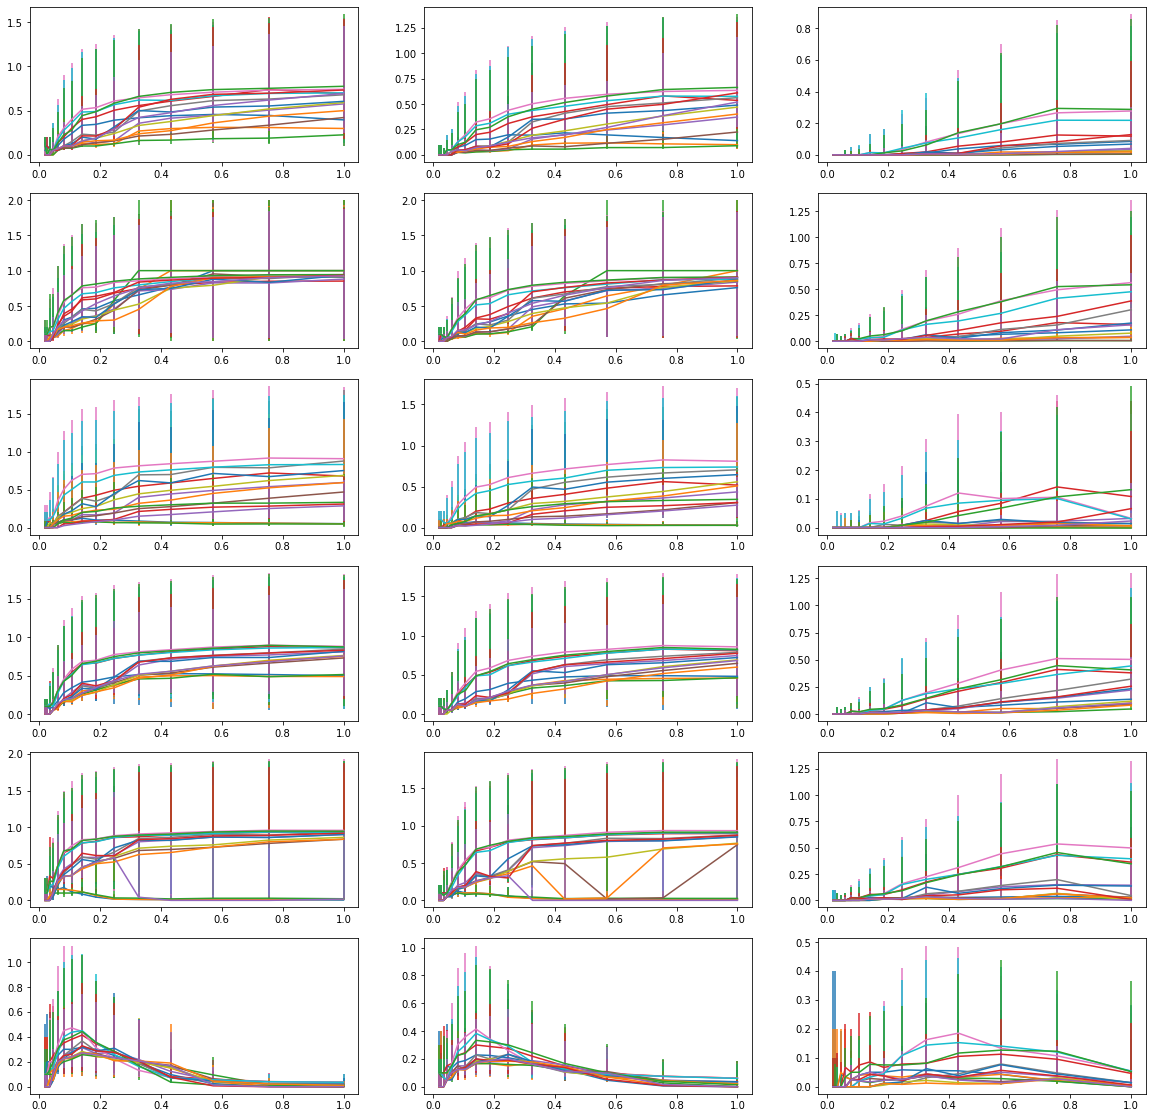

In [64]:
# Fix the selection method, and noise/np case, then plot across sparsity the 
fig, ax = plt.subplots(len(selection_methods), 3, figsize = (20, 20))
for i, selection_method in enumerate(selection_methods):
    for case in range(3):
        a = ax [i, case]        
        # Plot curves across sparsity for each algorithm, with errorbars
        for dframe in dframe_names:
            # There are three correlation conditions. Co-plot them for now (ew)
            for cidx_group in range(3):
                df_ = apply_df_filters(efprfnr, selection_method=selection_method, case=case + 1,
                       df_name=dframe, cidx_group=cidx_group)
                sparsity_ = df_['sparsity'].values
                sparsity_ordering = np.argsort(sparsity_)
                yerr = np.array([df_['q25FNR'].values[sparsity_ordering], 
                                 df_['q75FNR'].values[sparsity_ordering]])
                a.errorbar(sparsity_[sparsity_ordering], df_['medFNR'].values[sparsity_ordering], 
                           yerr=yerr)

In [ ]:
# There is more variation within correlation than across sparsity. Therefore, group things into 3 bins based
# on "sparse", "intermediate density", and "dense" model and then examine the expected rate across alpha and 
# different data availability regimes

In [23]:
np.unique(alpha_datalist['np_ratio'].values)

array([ 2,  4,  8, 16])

In [32]:
np.unique(alpha_datalist['kappa'].values)

array([ 1,  2,  5, 10])

In [24]:
sparsity

array([0.02      , 0.02644752, 0.03497357, 0.04624822, 0.06115754,
       0.08087327, 0.10694488, 0.14142136, 0.18701223, 0.2473005 ,
       0.32702428, 0.4324491 , 0.57186037, 0.7562145 , 1.        ])

#### Calculation across sparsity groups

In [39]:
def calc2_(alpha_df, case_params, caseno=1):
    results_list =[]    
        
    # Narrow down dframes to case params
    case_dframes = [apply_df_filters(df, **case_params) for df in dframes]
    
    dframe_names = ['UoI Lasso', 'Lasso', 'MCP', 'EN', 'SCAD']
    selection_methods = ['AIC', 'BIC', 'CV', 'gMDL', 'empirical_bayes', 'oracle']
    betawidths = np.unique(alpha_df['betawidth'].values)
        
    for i, dframe in enumerate(case_dframes):
        for sm in selection_methods:
            for bw in betawidths:
                sparsity_groups = np.array_split(sparsity, 3)
                # Filter the sparsity into 3 equal bins
                for j, spgroup in enumerate(sparsity_groups):
                    cadf = apply_df_filters(alpha_df, df_name = dframe_names[i], selection_method=sm,
                                            betawidth=bw)
                    cadf = cadf.loc[cadf['sparsity'].isin(spgroup)]
                    df_ = apply_df_filters(dframe, selection_method=sm)
                    df_ = df_.loc[df_['sparsity'].isin(spgroup)]                
                    # At this stage, only sparsity (5) should be residual
                    try:
                        assert(cadf.shape[0] == 5)
                    except:
                        pdb.set_trace()

                    alpha_table = {'alphas': [], 'cov_idxs': [], 'FNR': [], 'FPR': [],
                                   'EFPR' : [], 'EFNR' : [], 'stdFPR' : [], 'stdFNR' : [],
                                   'medFNR' : [], 'medFPR' : [], 'q25FPR' : [], 'q25FNR' : [],
                                   'q75FPR' : [], 'q75FNR' : []}
                    # For each value of alpha remaining, match up the vector of FNR and FPR
                    for k in range(cadf.shape[0]):
                        alphas = cadf.iloc[j]['alpha']
                        alpha_mask = np.ma.log(alphas)
                        mask = np.invert(alpha_mask.mask)
                        cov_idxs = cadf.iloc[j]['cov_indices'][mask]                
                        alpha_table['alphas'].append(np.log(alphas[mask]))
                        alpha_table['cov_idxs'].append(cov_idxs)
                        alpha_table['FNR'].append([])
                        alpha_table['FPR'].append([])

                        for cov_idx in cov_idxs:
                            df_row_ = apply_df_filters(df_, sparsity=cadf.iloc[j]['sparsity'], 
                                                       betawidth=cadf.iloc[j]['betawidth'],
                                                       cov_idx=cov_idx)
                            # Should be 20 reps at this stage
                            try:
                                assert(df_row_.shape[0] == 20)
                            except:
                                pdb.set_trace()
                            alpha_table['FNR'][k].append(df_row_['FNR'].values)
                            alpha_table['FPR'][k].append(df_row_['FPR'].values)

                    FNR = np.array(alpha_table['FNR'])
                    FPR = np.array(alpha_table['FPR'])

                    assert(FNR.ndim == 3)
                    assert(FPR.ndim == 3)

                    # Array is of shape (sparsity * betawidth, n_alphas, reps)
                    # We need to take statistics across the first and third axes, so first reorder, then 
                    # reshape

                    FNR = np.swapaxes(FNR, 0, 1)
                    FPR = np.swapaxes(FPR, 0, 1)
                    FNR = np.reshape(FNR, (FNR.shape[0], - 1))
                    FPR = np.reshape(FPR, (FPR.shape[0], -1))


                    alpha_table['EFNR'] = np.mean(FNR, axis=1)
                    alpha_table['EFPR'] = np.mean(FPR, axis=1)

                    alpha_table['stdFNR'] = np.std(FNR, axis=1)
                    alpha_table['stdFPR'] = np.std(FPR, axis=1)

                    alpha_table['medFNR'] = np.median(FNR, axis = 1)
                    alpha_table['medFPR'] = np.median(FPR, axis = 1)

                    q25FNR, q75FNR = np.percentile(FNR, [25, 75], axis=1)                
                    q25FPR, q75FPR = np.percentile(FPR, [25, 75], axis=1)

                    alpha_table['q25FNR'] = q25FNR
                    alpha_table['q25FPR'] = q25FPR
                    alpha_table['q75FNR'] = q75FNR
                    alpha_table['q75FPR'] = q75FPR  

                    # Append results
                    results = {'df_name': dframe_names[i], 'selection_method': sm, 'betawidth' : bw,
                               'spgroup': j,'case': caseno, 'alpha_table': alpha_table}
                    results.update(case_params)
                    results_list.append(results)
    return results_list

In [40]:
efprfnr2 = []    
t0 = time.time()

# High noise, normal n/p ratio
case1 = apply_df_filters(alpha_datalist, kappa=1, np_ratio=4)
efprfnr2.extend(calc2_(case1, {'kappa' : 1, 'np_ratio': 4}, 1))

# Normal noise, low data
case2 = apply_df_filters(alpha_datalist, kappa=5, np_ratio=2)
efprfnr2.extend(calc2_(case2, {'kappa' : 5, 'np_ratio': 2}, 2))

# ideal
case3 = apply_df_filters(alpha_datalist, kappa=10, np_ratio=16)
efprfnr2.extend(calc2_(case3, {'kappa' : 10, 'np_ratio': 16}, 3))

In [41]:
efprfnr2 = pd.DataFrame(efprfnr2)

In [42]:
dframe_names = np.unique(efprfnr2['df_name'].values)

In [43]:
selection_methods = np.unique(efprfnr2['selection_method'].values)

In [50]:
from scipy import signal

In [51]:
# Low pass filter the signal y(x)
# f0: filter cutoff frequency
def lpfilter(y, f0):
    
    # 2nd order lowpass butterworth filter
    b, a = signal.butter(2, f0)
    
    z = signal.filtfilt(b, a, y)
    return z

> <ipython-input-59-20103317b5d9>(33)<module>()
-> yy = lpfilter(yy, 0.05)
(Pdb) yp
array([0.825, 0.2  , 0.2  , 0.3  , 0.2  , 0.5  , 0.2  , 0.1  , 0.2  ,
       0.2  , 0.2  , 0.3  , 0.2  , 0.2  , 0.2  , 0.2  , 0.2  , 0.2  ,
       0.2  , 0.3  , 0.2  , 0.2  , 0.2  , 0.2  , 0.2  , 0.2  , 0.2  ,
       0.55 , 0.2  , 0.2  , 0.2  , 0.3  , 0.4  , 0.2  , 0.2  ])
(Pdb) yy.shape
(35,)
(Pdb) alpha_table['q75FNR'][alpha_ordering]
array([0.425, 0.1  , 0.1  , 0.2  , 0.1  , 0.3  , 0.1  , 0.1  , 0.1  ,
       0.1  , 0.1  , 0.2  , 0.1  , 0.1  , 0.1  , 0.1  , 0.1  , 0.1  ,
       0.1  , 0.2  , 0.1  , 0.1  , 0.1  , 0.1  , 0.1  , 0.1  , 0.1  ,
       0.3  , 0.1  , 0.1  , 0.1  , 0.2  , 0.2  , 0.1  , 0.1  ])
(Pdb) yy
array([0.4 , 0.1 , 0.1 , 0.1 , 0.1 , 0.2 , 0.1 , 0.  , 0.1 , 0.1 , 0.1 ,
       0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ,
       0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.25, 0.1 , 0.1 , 0.1 , 0.1 , 0.2 ,
       0.1 , 0.1 ])
(Pdb) quit()


BdbQuit: 

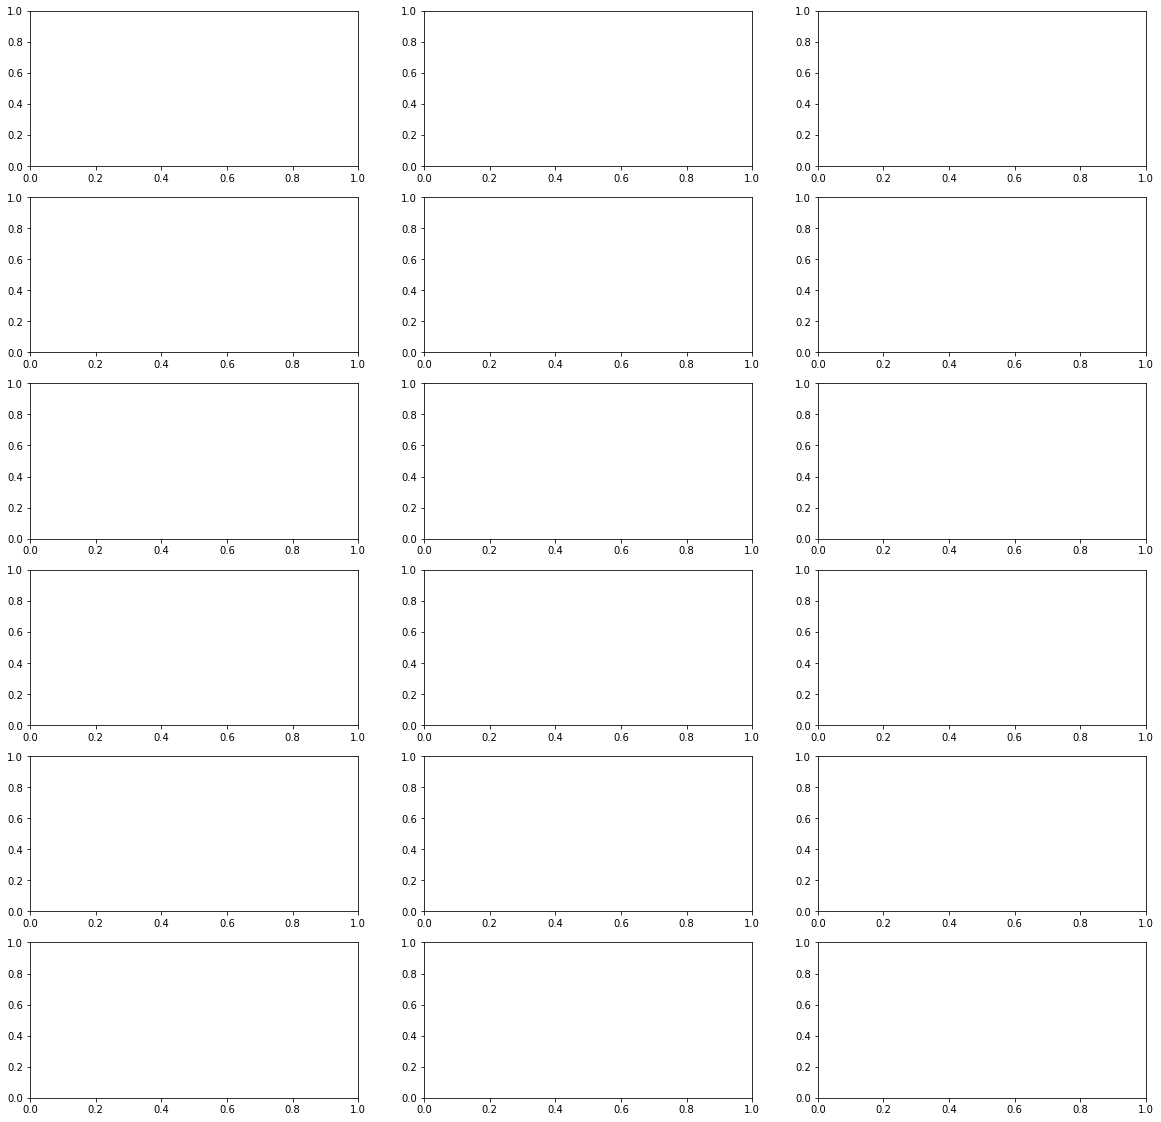

In [59]:
# Fix the selection method, and noise/np case, then plot vs. alpha for each sparsity 
fig, ax = plt.subplots(len(selection_methods), 3, figsize = (20, 20))
for i, selection_method in enumerate(selection_methods):
    for case in range(3):
        a = ax[i, case]        
        # Plot curves across sparsity for each algorithm, with errorbars
        for dframe in dframe_names:
            # There are three sparsity conditions. Co-plot them for now (ew)
            for spgroup in range(3):
                df_ = apply_df_filters(efprfnr2, selection_method=selection_method, case=case + 1,
                       df_name=dframe, spgroup=spgroup, betawidth=np.inf)

                alpha_table = df_['alpha_table'].iloc[0]

                # Make sure that all 15 lists have the same number of elements by asserting that a 2D
                # array is formed
                alphas = np.array(alpha_table['alphas'])
                assert(alphas.ndim == 2)
                # Also ensure that all alphas are the same across rows
                assert(np.isclose(alphas, alphas[0]).all())

                # Do mean and standard deviation 
                alphas_ = alphas[0, :]
                alpha_ordering = np.argsort(alphas_)
                                
                # Smooth the base signal and the confidence bounds
                yy = alpha_table['medFNR'][alpha_ordering]
                yp = yy + alpha_table['q75FNR'][alpha_ordering]
                ym = yy - alpha_table['q25FNR'][alpha_ordering]
                                
                yy = lpfilter(yy, 0.05)
                yp = lpfilter(yp, 0.99)
                ym = lpfilter(ym, 0.99)
            
                # Truncate the confidence intervals between 0 and 1
                yp = np.minimum(np.ones(yp.size), yp)
                ym = np.maximum(np.zeros(ym.size), ym)
                
                a.plot(alphas_[alpha_ordering], yy)
                a.fill_between(alphas_[alpha_ordering], ym, yp, alpha=0.2)


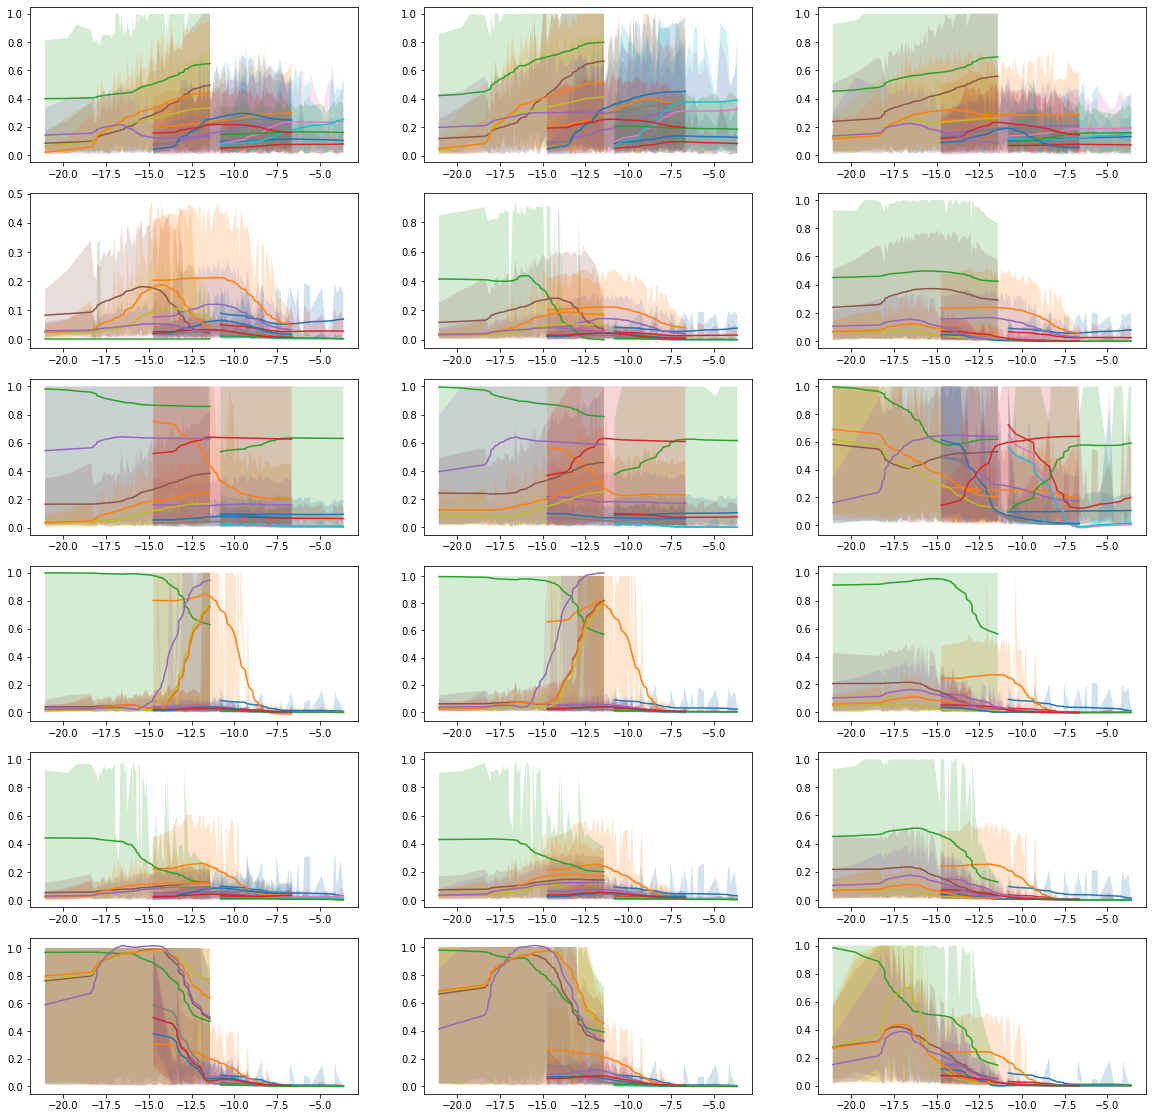

In [60]:
# Fix the selection method, and noise/np case, then plot vs. alpha for each sparsity 
fig, ax = plt.subplots(len(selection_methods), 3, figsize = (20, 20))
for i, selection_method in enumerate(selection_methods):
    for case in range(3):
        a = ax[i, case]        
        # Plot curves across sparsity for each algorithm, with errorbars
        for dframe in dframe_names:
            # There are three sparsity conditions. Co-plot them for now (ew)
            for spgroup in range(3):
                df_ = apply_df_filters(efprfnr2, selection_method=selection_method, case=case + 1,
                       df_name=dframe, spgroup=spgroup, betawidth=np.inf)

                alpha_table = df_['alpha_table'].iloc[0]

                # Make sure that all 15 lists have the same number of elements by asserting that a 2D
                # array is formed
                alphas = np.array(alpha_table['alphas'])
                assert(alphas.ndim == 2)
                # Also ensure that all alphas are the same across rows
                assert(np.isclose(alphas, alphas[0]).all())

                # Do mean and standard deviation 
                alphas_ = alphas[0, :]
                alpha_ordering = np.argsort(alphas_)
                                
                # Smooth the base signal and the confidence bounds
                yy = alpha_table['medFPR'][alpha_ordering]
                yp = yy + alpha_table['q75FPR'][alpha_ordering]
                ym = yy - alpha_table['q25FPR'][alpha_ordering]
                                
                yy = lpfilter(yy, 0.05)
                yp = lpfilter(yp, 0.99)
                ym = lpfilter(ym, 0.99)
            
                # Truncate the confidence intervals between 0 and 1
                yp = np.minimum(np.ones(yp.size), yp)
                ym = np.maximum(np.zeros(ym.size), ym)
                
                a.plot(alphas_[alpha_ordering], yy)
                a.fill_between(alphas_[alpha_ordering], ym, yp, alpha=0.2)


In [ ]:
# Plot the variance or interquartile ranges separately, as there appear to be interesting variations between 
# the algorithms 

In [ ]:
# Might be enough here if we simplify the presentation and deal with the discontinuities. 
# Perhaps cutoff some of the more correlated cases